In [223]:
import torch
import numpy as np

In [224]:
torch.__version__


'2.5.1+cpu'

In [225]:
import chess

In [226]:
fen="5r1k/4b1p1/2p3qp/3n3r/2B1p3/4P1P1/Q2B1P1P/2R1R1K1 b - - 2 45"

In [227]:
from itertools import chain
import re

class FenParser():
    def __init__(self, fen_str):
        self.fen_str = fen_str

    def parse(self):
        ranks = self.fen_str.split(" ")[0].split("/")
        pieces_on_all_ranks = [self.parse_rank(rank) for rank in ranks]
        return pieces_on_all_ranks

    def parse_rank(self, rank):
        rank_re = re.compile("(\\d|[kqbnrpKQBNRP])")
        piece_tokens = rank_re.findall(rank)
        pieces = self.flatten(map(self.expand_or_noop, piece_tokens))
        return pieces

    def flatten(self, lst):
        return list(chain(*lst))

    def expand_or_noop(self, piece_str):
        piece_re = re.compile("([kqbnrpKQBNRP])")
        retval = ""
        if piece_re.match(piece_str):
          retval = piece_str
        else:
          retval = self.expand(piece_str)
        
        return retval

    def expand(self, num_str):
        return int(num_str)*" "

    def white_to_move(self):
        return True if self.fen_str.split()[1] == 'w' else False

    def can_castle(self, color, side):
        castling_rights = self.fen_str.split()[2]
        
        if castling_rights == '-':
            return False

        if color == 'w':
            if side == 'k':
                return True if 'K' in castling_rights else False
            elif side == 'q':
                return True if 'Q' in castling_rights else False

        if color == 'b':
            if side == 'k':
                return True if 'k' in castling_rights else False
            elif side == 'q':
                return True if 'q' in castling_rights else False

        return False

    def get_board(self):
        return chess.Board(self.fen_str)

    def legal_moves(self):
        return self.get_board().legal_moves
        

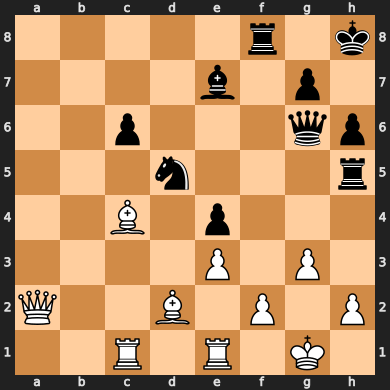

In [228]:
fp = FenParser(fen)
fp.get_board()


In [229]:
from functools import partial

# Map square to (row, col) and vice versa
def square_to_coords(square):
    return square // 8, square % 8

def coords_to_square(row, col):
    return row * 8 + col


def create_edges() -> torch.Tensor:

    edge_index = []

    def add_edges(moves, square, row, col):
        for dr, dc in moves:
            nr, nc = row + dr, col + dc
            if 0 <= nr < 8 and 0 <= nc < 8:
                target_square = coords_to_square(nr, nc)
                edge_index.append([square, target_square])
        
    # Total nodes (squares)
    num_nodes = 64

    # Directions for knight moves
    knight_moves = [
        (-2, -1), (-2, 1), (-1, -2), (-1, 2),
        (1, -2), (1, 2), (2, -1), (2, 1)
    ]
    
    # Directions for queen moves (also covers other piece moves)
    queen_moves = [
        (dx, dy)
        for dx in range(-7, 8) for dy in range(-7, 8)
        if (dx == 0) != (dy == 0) or abs(dx) == abs(dy)
    ]

    # Add edges for each square
    for square in range(num_nodes):
        row, col = square_to_coords(square)
        add_edges_for_square = partial(add_edges, square=square, col=col, row=row)

        # loop through knight/queen moves
        add_edges_for_square(knight_moves)
        add_edges_for_square(queen_moves)

    # Convert edge list to tensor
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

edge_index = create_edges()
print("Edge Index:", edge_index)
print("Number of Edges:", edge_index.size(1))

Edge Index: tensor([[ 0,  0,  0,  ..., 63, 63, 63],
        [10, 17,  0,  ..., 61, 62, 63]])
Number of Edges: 1856


In [230]:
def calculate_inverse_output(input_value: str) -> int:
    """
    Define the range of the output values checkmate in 100 moves is equivalent 
    to +10 evaluation and mate in 1 move is equivalent to +75 evaluation
    """
    max_output = 99_000
    min_output = 1_000
    
    # Calculate the output using an inverse proportional formula
    output = max_output - (input_value * (max_output - min_output) / 99)
    return int(max(min_output, min(max_output, output)))  # Clamp output within range


# there are evaluations in the range 1000 - 9999 which are unnecessary big -> might be good idea to normalize them
def normalize_evaluation(evaluation: int) -> float:
    """
    For centipawn evaluations, signed log transformation is often a good choice because:

    It compresses large values.
    It keeps smaller values distinguishable.
    It ensures a smooth distribution of data for regression.

    Why Normalize?

    1. Gradient Stability: Large differences in target values can lead to large gradients during backpropagation, which may destabilize training or cause slower convergence.
    2. Model Sensitivity: If the majority of your data lies in the 0–100 range but you also have outliers in the 1000–9999 range, the model might overfit or focus disproportionately on these outliers.
    3. Consistency: Normalizing the data ensures all values are on a similar scale, making the model's predictions more interpretable.
    """
    data = torch.tensor([evaluation], dtype=torch.float)
    return torch.sign(data) * torch.log(torch.abs(data) + 1)


def denormalize_evaluation(normalized_data: float) -> float:
    return np.sign(normalized_data) * (np.expm1(np.abs(normalized_data)))


def parse_evaluation(evaluation: str) -> int:
    # in centipawns  
    evaluation = evaluation.strip()
    
    # evaluate checkmates (e.g. #+63 / #-0)
    if evaluation.startswith('#'):
        evaluation = evaluation.lstrip('#+')

        if evaluation.startswith('-'):
            black_to_move = True
        else:
            black_to_move = False

        evaluation = abs(int(evaluation))

        if evaluation == 0:
            evaluation = 10_000
        else:
            evaluation = calculate_inverse_output(evaluation)

        return -1*evaluation if black_to_move else evaluation

    return int(evaluation)


def parse_chess_data(chess_data: str) -> list:
    """
    Parse fen and evaluation from the raw data
    
    Parameters: 
        chess_data:
    r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q1PP/R1B1K2R w KQkq - 4 12,+115  
    """
    fen, evaluation = chess_data.split(',')
    return FenParser(fen), parse_evaluation(evaluation) 


evaluation = -20
print(f"Evaluation: {evaluation}")
normalizd = normalize_evaluation(evaluation)
print(f"Normalizd: {normalizd}")
print(f"Normalizd: {denormalize_evaluation(normalizd)}")

evaluation = -2000
print(f"Evaluation: {evaluation}")
normalizd = normalize_evaluation(evaluation)
print(f"Normalizd: {normalizd}")
print(f"Normalizd: {denormalize_evaluation(normalizd)}")

evaluation = "#-4"
evaluation = parse_evaluation(evaluation)
print(f"Evaluation: {evaluation}")
normalizd = normalize_evaluation(evaluation)
print(f"Normalizd: {normalizd}")
print(f"Normalizd: {denormalize_evaluation(normalizd)}")

Evaluation: -20
Normalizd: tensor([-3.0445])
Normalizd: tensor([-20.0000])
Evaluation: -2000
Normalizd: tensor([-7.6014])
Normalizd: tensor([-1999.9999])
Evaluation: -95040
Normalizd: tensor([-11.4621])
Normalizd: tensor([-95040.0156])


/tmp/ipykernel_26244/3457003888.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sign(normalized_data) * (np.expm1(np.abs(normalized_data)))


In [231]:
parse_chess_data("r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q1PP/R1B1K2R w KQkq - 4 12,+115")
parse_chess_data("r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q1PP/R1B1K2R w KQkq - 4 12,#-15")

(<__main__.FenParser at 0x7fae3279d580>, -84151)

In [232]:
# node features: these represent the pieces on the squares (nodes)

def piece_to_tensor(piece: str) -> torch.tensor:
    piece = chess.Piece.from_symbol(piece)
    node_feature = torch.zeros(13)
    node_feature[piece.__hash__() + 1] = 1
    return node_feature

def fen_to_node_features(fen):    
    num_nodes = 64
    node_features = torch.zeros((num_nodes, 13))
    
    for i,row in enumerate(list(reversed(fen.parse()))):
        for j, square in enumerate(row):
            if len(square.strip()) > 0:
                node_features[chess.square(j, i)] = piece_to_tensor(square)

            # whose turn it's to move
            # NOTE: this could be encoded also as a global feature for the whole graph
            # but we'll do it like this for simplicity
            if fen.white_to_move():
                node_features[chess.square(j, i)][0] = 1

    return node_features

node_features = fen_to_node_features(FenParser(fen))


In [233]:
# edge features: these represent legal moves between squares (nodes)

def alphabetical_distance(char1, char2):
    return abs(ord(char1.lower()) - ord(char2.lower()))

def fen_to_edge_features(fen_parser, edges):

    # initialize edge feature tensor
    edge_features = torch.zeros((edges.size(1), 17))

    white_to_move = fen_parser.white_to_move()

    # 1. map pieces to squares
    pieces = {}
    for i,row in enumerate(list(reversed(fen_parser.parse()))):
        for j, square in enumerate(row):
            if len(square.strip()) > 0:
                pieces[chess.square(j, i)] = chess.Piece.from_symbol(square)

    moves = 0
    promoted = []
    promote = False
    
    for move in fen_parser.legal_moves():

        # move is in uci format (e.g. e2e4)
        moves += 1
        move = str(move)

        # pawn promotions looks like this: a7b8Q (only moves where length > 4)
        # there is alway 4 possible promotions but we are interested only from
        # queen promotions for now, so we skip the rest of the possible promotions
        if len(move) > 4:
            move = move[:4]
            if move in promoted:
                continue
            promoted.append(move)
            promote = True

        start, end = chess.parse_square(move[:2]), chess.parse_square(move[2:])

        # calculate correct edge index from start/end
        value_pair = torch.tensor([start, end])  
        edge = torch.where((edges[0] == value_pair[0]) & (edges[1] == value_pair[1]))[0].item()

        # legal move
        edge_features[edge][0] = 1

        # edge length
        edge_features[edge][1] = abs(int(move[1]) - int(move[3]))
        edge_features[edge][2] = alphabetical_distance(move[0], move[2])

        # what piece is moved
        if pieces[start].piece_type == 1:
            # pawn
            if white_to_move:
                edge_features[edge][3] = 1
            else:
                edge_features[edge][4] = 1
        elif pieces[start].piece_type == 6:
            # king
            if white_to_move:
                edge_features[edge][5] = 1
            else:
                edge_features[edge][6] = 1
        elif pieces[start].piece_type == 5:
            # queen
            edge_features[edge][7] = 1
        elif pieces[start].piece_type == 2:
            # knight
            edge_features[edge][8] = 1
        elif pieces[start].piece_type == 3:
            # bishop
            edge_features[edge][9] = 1
        elif pieces[start].piece_type == 4:
            # rook
            edge_features[edge][10] = 1
        else:
            assert False, f"Did not recognize piece symbol: {pieces[start].piece_type}"
        
        # castling
        if move == "e1g1" and fen_parser.can_castle('w', 'k'):
            edge_features[edge][12] = 1
        if move == "e1c1" and fen_parser.can_castle('w', 'q'):
            edge_features[edge][13] = 1
        if move == "e8g8" and fen_parser.can_castle('b', 'k'):
            edge_features[edge][14] = 1
        if move == "e8c8" and fen_parser.can_castle('b', 'q'):
            edge_features[edge][15] = 1
        
        # pawn promotion 
        if promote:
            edge_features[edge][16] = 1
            promote = False
     
        #print(edge_features[edge])

    return edge_features


edge_features = fen_to_edge_features(FenParser(fen), create_edges())
edge_features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [234]:
from torch_geometric.data import Data

# Create the pytorch_geometric data object
graph = Data(
    x=fen_to_node_features(FenParser(fen)), 
    edge_index=edge_index,
    edge_attr=fen_to_edge_features(FenParser(fen), create_edges())
)

print(graph)
torch.save(graph, "test_graph.pt")

Data(x=[64, 13], edge_index=[2, 1856], edge_attr=[1856, 17])


In [235]:
# one graph is ~150kb, so creating 13M of these takes about 2TB disk space
# -> create graphs on the fly for now
from torch_geometric.data import Dataset

def create_graph_from_fen(fen_parser: str, edges) -> Data:
    return Data(
        x=fen_to_node_features(fen_parser), 
        edge_index=edges,
        edge_attr=fen_to_edge_features(fen_parser, edges)
    )


class FENDataset(Dataset):
    def __init__(self, fen_file, transform=None, pre_transform=None):
        super().__init__(None, transform, pre_transform)
        with open(fen_file, 'r') as f:
            self.fen_list = [line.strip() for line in f]

        self.edges = create_edges()
        self.cache = {}

    def len(self):
        return len(self.fen_list)

    def get(self, idx):

        if idx in self.cache:
            return self.cache[idx]
            
        fen_str = self.fen_list[idx]
        fen_parser, evaluation = parse_chess_data(fen_str)
        graph = create_graph_from_fen(fen_parser, self.edges)  

        # store the evaluation
        graph.y = normalize_evaluation(evaluation)

        self.cache[idx] = graph
        
        return graph

#dataset = FENDataset('chessData.csv')
dataset = FENDataset('first_10k_evaluations.csv')

In [236]:
import gc
gc.collect()

1793

In [237]:
class GNNModel(torch.nn.Module):
    def __init__(self, num_features=13, hidden_size=64, target_size=1):
        super(GNNModel, self).__init__()
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.target_size = target_size
        self.convs = [GATConv(self.num_features, self.hidden_size, edge_dim=17),
                      GATConv(self.hidden_size, self.hidden_size, edge_dim=17)]
        self.linear = nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        for conv in self.convs[:-1]:
            x = conv(x=x, edge_index=edge_index, edge_attr=edge_attr) # adding edge features here!
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x=x, edge_index=edge_index, edge_attr=edge_attr) # edge features here as well

        # Global mean pooling: aggregate node features to get a graph-level embedding
        x = global_mean_pool(x, batch)  # 'batch' tensor tells which nodes belong to which graph

        x = self.linear(x)
        return x


In [238]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax


# Custom Message Passing Layer
class CustomMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels, aggr='add'):
        super(CustomMessagePassing, self).__init__(aggr=aggr)
        self.linear = nn.Linear(in_channels, out_channels)
        self.edge_encoder = nn.Linear(17, out_channels)

    def forward(self, x, edge_index, edge_attr=None):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        if edge_attr is not None:
            edge_embedding = self.edge_encoder(edge_attr)
            return self.linear(x_j) + edge_embedding
        return self.linear(x_j)

    def update(self, aggr_out):
        return aggr_out


# Attention-Based Global Pooling
class AttentionGlobalPooling(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(AttentionGlobalPooling, self).__init__()
        self.attention_mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    def forward(self, x):
        # Compute attention scores
        attention_scores = self.attention_mlp(x)  # [num_nodes, 1]
        attention_scores = F.softmax(attention_scores, dim=0)  # Normalize across all nodes

        # Apply attention scores to node features
        x_weighted = x * attention_scores  # Element-wise multiplication

        # Aggregate node features (sum)
        graph_embedding = x_weighted.sum(dim=0)  # [in_channels]
        return graph_embedding


# EPD GNN Architecture for a Single Graph
class AttentionEPDGNN(nn.Module):
    def __init__(self, in_channels=13, hidden_channels=64, out_channels=1, num_processors=2):
        super(AttentionEPDGNN, self).__init__()

        # Encoder: Node feature transformation
        # Raw node features (like piece type, color, position) are usually sparse or simple.
        # The encoder learns a richer, task-specific representation in the hidden embedding space.
        self.encoder = nn.Linear(in_channels, hidden_channels)

        # Processor: Stack of message-passing layers
        self.processors = nn.ModuleList([
            CustomMessagePassing(hidden_channels, hidden_channels)
            for _ in range(num_processors)
        ])

        # Attention-based global pooling
        self.attention_pooling = AttentionGlobalPooling(hidden_channels, hidden_channels // 2)

        # Decoder: Fully connected layers for graph-level output
        self.decoder = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, out_channels)
        )

    def forward(self, x, edge_index, edge_attr=None):
        # Encoder: Transform node features
        x = self.encoder(x)
        x = F.relu(x)

        # Processor: Message passing layers
        for processor in self.processors:
            x = processor(x, edge_index, edge_attr=edge_attr)
            x = F.relu(x)

        # Attention-based pooling for aggregating graph-wide information
        graph_embedding = self.attention_pooling(x)

        # Decoder: Predict graph-level output
        out = self.decoder(graph_embedding)
        return out


# Example Usage with a Single Graph

# 10 nodes with 8-dimensional features
x = torch.rand((10, 8))  

# Random edge indexes
edge_index = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                           [1, 0, 3, 2, 5, 4, 7, 6, 9, 8]], dtype=torch.long)
# Random edge features
edge_attr = torch.rand((10, 17))

# Create model
model = AttentionEPDGNN(in_channels=8, hidden_channels=64, out_channels=1)

# Forward pass
output = model(x, edge_index, edge_attr=edge_attr)
print("Graph-level output:", output)



Graph-level output: tensor([0.0987], grad_fn=<ViewBackward0>)


In [239]:
# Separate data to training, validation and testing sets

from torch_geometric.data import DataLoader
from torch.utils.data import random_split

# Define lengths for train, validation, and test
train_len = int(0.7 * len(dataset))  # 70% for training
val_len = int(0.15 * len(dataset))   # 15% for validation
test_len = len(dataset) - train_len - val_len  # 15% for testing

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for batch in train_loader:
    batch = batch.to('cpu')
    print(batch)
    break


DataBatch(x=[2048, 13], edge_index=[2, 59392], edge_attr=[59392, 17], y=[32], batch=[2048], ptr=[33])


In [240]:
# Training loop

import torch
import torch.optim as optim

# Hyperparameters
in_channels = 13
hidden_channels = 64
num_iterations = 3

# Model
model = AttentionEPDGNN(
    in_channels=in_channels, 
    hidden_channels=hidden_channels, 
    out_channels=1
)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mean Squared Error for regression (centipawn evaluation)
criterion = torch.nn.MSELoss() 

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
epochs = 2
for epoch in range(epochs):

    # Set model to training mode
    model.train()
    
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch in train_loader:
        batch = batch.to(device)  # Move batch to device (GPU or CPU)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass: Get model predictions
        output = model(batch.x, batch.edge_index, edge_attr=batch.edge_attr)
        
        # Calculate the loss
        loss = criterion(output, batch.y) 
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimizer step
        
        # Track loss and accuracy
        train_loss += loss.item()
        predicted = output.squeeze()
        correct += (predicted == batch.y).sum().item()
        total += batch.num_graphs  # Total number of graphs in the batch
    
    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / total
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy*100:.2f}%')
    
    # Validation step (no gradients needed)
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradients needed during validation
        for batch in val_loader:
            batch = batch.to(device)
            
            output = model(batch.x, batch.edge_index, edge_attr=batch.edge_attr)
            loss = criterion(output, batch.y)
            val_loss += loss.item()
            
            # Accuracy calculation
            predicted = output.squeeze()
            total += batch.num_graphs
            correct += (predicted == batch.y).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy*100:.2f}%')

# Test after training is done
model.eval()  # Set model to evaluation mode for testing
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        
        output = model(batch.x, batch.edge_index, batch.edge_attr)
        loss = criterion(output, batch.y)
        test_loss += loss.item()
        
        # Accuracy calculation
        predicted = output.squeeze()
        total += batch.num_graphs
        correct += (predicted == batch.y).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy*100:.2f}%')



Epoch 1/2, Loss: 22.2782, Accuracy: 0.00%
Validation Loss: 21.3796, Accuracy: 0.00%
Epoch 2/2, Loss: 21.0477, Accuracy: 0.00%
Validation Loss: 21.4662, Accuracy: 0.00%
Test Loss: 20.3981, Accuracy: 0.00%


In [187]:
import os
print(os.getcwd())

checkpoint = 'model_checkpoint_001.pt'

torch.save({
    'epoch': epoch + 1,                  # Save the current epoch number
    'model_state_dict': model.state_dict(),  # Save the model's weights
    'optimizer_state_dict': optimizer.state_dict(),  # Save the optimizer's state
    'loss': loss.item(),                 # Save the current loss value
}, checkpoint)  # Specify the filename

print(f"Checkpoint saved to: {checkpoint}")

/home/laineo/Work/notebooks
Checkpoint saved to: model_checkpoint_001.pt
